In [1]:
%load_ext autoreload
%autoreload 2

from src.sampling.main import stratified_spatial_sampling_dual, stratified_spatial_kfold_dual
from dataset.weather_graph_dataset import WeatherGraphDatasetWithRadar, WeatherGraphDatasetNew

import torch
from torch_geometric.data import HeteroData
from src.raingauge.utils import (
    get_station_coordinate_mappings,
    load_weather_station_dataset,
)
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from scipy.stats import pearsonr
from src.radar.utils import load_radar_dataset
from src.visualization.main import pandas_to_geodataframe, visualise_singapore_outline
from src.visualization.radar import (
    improved_visualise_radar_grid,
    visualize_one_radar_image_with_cropping,
    visualize_one_radar_image,
)
from src.visualization.raingauge import visualise_gauge_grid
import cartopy.crs as ccrs
import matplotlib as mpl
from src.radar.preprocessor import RadarPreprocessor
from scipy.spatial import cKDTree
from src.miscellaneous import get_straight_distance
from models.gnn_radar import HeteroGNN_WithRadar
from models.gnn import HeteroGNN
import logging
from datetime import datetime
from src.performance_logger import PerformanceLogger
import os
from src.utils import add_weather_station_data, add_mask_to_data, generate_edges, add_edge_attributes_to_data, print_data_structure, prepare_dataset_new

/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# NOTE: Geographic extent of Singapore in longitude and latitude
bounds_singapore = {"left": 103.6, "right": 104.1, "top": 1.5, "bottom": 1.188}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20]
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend="both")

experiment_name = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_new"
os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
perf = PerformanceLogger(f"experiments/{experiment_name}/training_log.jsonl")

# Preprocess Radar Data

## Will find common data between radar and weather station

In [3]:
# print("=== Radar Image Preprocessing ===\n")

# # Load weather station data
# # Assuming weather_station_df_pivot is available from your main script
# # You'll need to load this from your saved data or regenerate it
# try:
#     weather_station_data = load_weather_station_dataset("weather_station_data.csv")
#     weather_station_locations = get_station_coordinate_mappings()

#     cols = list(weather_station_data.columns)
#     cols.remove("time_sgt")
#     cols.remove("gid")

#     weather_station_df_pivot = (
#         pd.pivot(data=weather_station_data, index="time_sgt", columns="gid", values=cols)
#         .resample("15min")
#         .first()
#     )

#     print(f"Loaded weather station data: {weather_station_df_pivot.shape[0]} timestamps")

# except Exception as e:
#     print(f"Error loading weather station data: {e}")

# # Initialize preprocessor
# preprocessor = RadarPreprocessor(
#     radar_base_path="database/sg_radar_data",
#     output_path="database/sg_radar_data_cropped",
#     weather_station_df=weather_station_df_pivot,
# )

# # Step 1: Get all radar files
# print("\nStep 1: Scanning radar files...")
# radar_files = preprocessor.get_all_radar_files()

# if len(radar_files) == 0:
#     print("No radar files found! Please check the radar_base_path.")

# print(f"Found {len(radar_files)} radar files")
# print(f"Date range: {radar_files[0][0]} to {radar_files[-1][0]}")

# # Step 2: Match with weather data
# print("\nStep 2: Matching with weather station data...")
# matched_radar_df, matched_weather_df = preprocessor.match_with_weather_data(radar_files)

# if len(matched_radar_df) == 0:
#     raise ValueError("No matching timestamps found!")

# # Step 3: Process and crop all matched files
# print("\nStep 3: Cropping radar images to Singapore bounds...")
# results_df = preprocessor.process_all_matched_files(matched_radar_df)

# # Step 4: Save metadata
# preprocessor.save_metadata(results_df)

# # Save matched weather dataframe
# matched_weather_path = preprocessor.output_path / "matched_weather_station_data.csv"
# matched_weather_df.to_csv(matched_weather_path)
# print(f"Matched weather station data saved to: {matched_weather_path}")

# print("\n=== Preprocessing Complete ===")
# print(f"Cropped radar images saved to: {preprocessor.output_path}")

In [4]:
# radar_df = load_radar_dataset("sg_radar_data_cropped", cropped=True)
# visualize_one_radar_image(radar_df=radar_df, n=1)

# Preprocess Radar Station Data

In [5]:
# data = HeteroData()
# data1 = HeteroData()
data2 = HeteroData()
# data3 = HeteroData()
# data4 = HeteroData()
dtype = torch.float32
# radius_km = (
#     5  # Depends on the radius we want to connect the radar grid to weather stations
# )

# # ---- 1) prepare station ID list
# weather_station_df_pivot["rain_rate"] *= 12
# station_ids = sorted({col[1] for col in weather_station_df_pivot.columns})

# # ---- 2) count observations per variable/station
# station_counts = weather_station_df_pivot.count().reset_index()
# weather_station_info = pd.pivot(station_counts, index="gid", columns="level_0")

# # ---- 3) prepare radar features
# radar_features, grid_coords, grid_shape = preprocessor.prepare_radar_features_temporal(
#     radar_df, weather_station_df_pivot
# )

# # ---- 4) classify rainfall vs general
# rainfall_station = [
#     gid for gid, row in weather_station_info.iterrows() if 0 in row.value_counts()
# ]

# general_station = [
#     s for s in weather_station_locations.keys() if s not in rainfall_station
# ]

# # restrict to stations actually present
# rainfall_station = [s for s in rainfall_station if s in weather_station_info.index]
# general_station = [s for s in general_station if s in weather_station_info.index]

# # ---- 5) build coordinate DF (always consistent)
# loc_df = pd.DataFrame.from_dict(
#     weather_station_locations, orient="index", columns=["latitude", "longitude"]
# )

# # ---- 6) flatten MultiIndex cols
# df_all = weather_station_info.copy()
# df_all.columns = [
#     "_".join([str(c) for c in col])  # tuple -> join
#     if isinstance(col, tuple)
#     else str(col)  # normal -> stringify
#     for col in df_all.columns
# ]

# # split
# df_rain = df_all.loc[rainfall_station].copy()
# df_gen = df_all.loc[general_station].copy()

# # ---- 7) attach coordinates (index matches)
# df_all = df_all.join(loc_df)
# df_rain = df_rain.join(loc_df)
# df_gen = df_gen.join(loc_df)

# # print(f"DF ALL: ",df_all.head())
# # print(f"DF RAIN: ",df_rain.head())
# # print(f"DF GEN: ",df_gen.head())

# # ---- 8) numpy coordinate arrays
# rain_coords = df_rain[["latitude", "longitude"]].to_numpy()
# gen_coords = df_gen[["latitude", "longitude"]].to_numpy()
# all_coords = df_all[["latitude", "longitude"]].to_numpy()

# # Convert radius to degrees
# # 111.0 km per degree is approximate conversion for latitude
# radius_deg = radius_km / 111.0

# # ---- 9) Radar to general stations
# tree_gen = cKDTree(gen_coords)
# radar_to_gen_list = tree_gen.query_ball_point(grid_coords, r=radius_deg)
# radar_to_gen_src = []
# radar_to_gen_dst = []
# radar_to_gen_distances = []

# for grid_idx, station_list in enumerate(radar_to_gen_list):
#     for station_idx in station_list:
#         # Use the same distance function as station-to-station edges
#         dist = get_straight_distance(
#             grid_coords[grid_idx],  # [lat, lon]
#             gen_coords[station_idx],  # [lat, lon]
#         )
#         if dist <= radius_km:
#             radar_to_gen_src.append(grid_idx)
#             radar_to_gen_dst.append(station_idx)
#             radar_to_gen_distances.append([dist])

# print(f"Radar to general station connections: {len(radar_to_gen_src)}")

# # ---- 10) Radar to rainfall stations
# tree_rain = cKDTree(rain_coords)
# radar_to_rain_list = tree_rain.query_ball_point(grid_coords, r=radius_deg)
# radar_to_rain_src = []
# radar_to_rain_dst = []
# radar_to_rain_distances = []

# for grid_idx, station_list in enumerate(radar_to_rain_list):
#     for station_idx in station_list:
#         dist = get_straight_distance(
#             grid_coords[grid_idx],  # [lat, lon]
#             rain_coords[station_idx],  # [lat, lon]
#         )
#         if dist <= radius_km:
#             radar_to_rain_src.append(grid_idx)
#             radar_to_rain_dst.append(station_idx)
#             radar_to_rain_distances.append([dist])

# print(f"Radar to rainfall station connections: {len(radar_to_rain_src)}")

# # TODO: Since radar grids are not prediction targets, it's latent features / spatial context providers, not necessary to have radar to radar edges
# # ---- 11) Radar to radar edges (radius-based, not connectivity-based)
# # radar_to_radar_edges = preprocessor.create_grid_edges_radius(grid_coords, radius_km)
# # print(f"Radar to radar edges: {radar_to_radar_edges.shape[1]} edges created")
# # print(f"First 10 radar-radar edges:\n{radar_to_radar_edges[:, :10]}")

# # ---- 12) Add radar node features to HeteroData
# data["radar_grid"].x = torch.tensor(radar_features, dtype=dtype)
# data["radar_grid"].y = torch.tensor(radar_features, dtype=dtype)

# # ---- 13) Add edges (with empty array handling)
# # Radar to general stations
# if len(radar_to_gen_src) > 0:
#     data["radar_grid", "radar_to_gen", "general_station"].edge_index = torch.tensor(
#         np.array([radar_to_gen_src, radar_to_gen_dst]), dtype=torch.long
#     )
#     data["general_station", "gen_to_radar", "radar_grid"].edge_index = torch.tensor(
#         np.array([radar_to_gen_dst, radar_to_gen_src]), dtype=torch.long
#     )
#     # Add distance attributes
#     data["radar_grid", "radar_to_gen", "general_station"].edge_attr = torch.tensor(
#         radar_to_gen_distances, dtype=dtype
#     )
#     data["general_station", "gen_to_radar", "radar_grid"].edge_attr = torch.tensor(
#         radar_to_gen_distances, dtype=dtype
#     )
# else:
#     print("WARNING: No radar to general station edges found within radius")
#     data["radar_grid", "radar_to_gen", "general_station"].edge_index = torch.empty(
#         (2, 0), dtype=torch.long
#     )
#     data["general_station", "gen_to_radar", "radar_grid"].edge_index = torch.empty(
#         (2, 0), dtype=torch.long
#     )
#     data["radar_grid", "radar_to_gen", "general_station"].edge_attr = torch.empty(
#         (0, 1), dtype=dtype
#     )
#     data["general_station", "gen_to_radar", "radar_grid"].edge_attr = torch.empty(
#         (0, 1), dtype=dtype
#     )

# # Radar to rainfall stations
# if len(radar_to_rain_src) > 0:
#     data["radar_grid", "radar_to_rain", "rainfall_station"].edge_index = torch.tensor(
#         np.array([radar_to_rain_src, radar_to_rain_dst]), dtype=torch.long
#     )
#     data["rainfall_station", "rain_to_radar", "radar_grid"].edge_index = torch.tensor(
#         np.array([radar_to_rain_dst, radar_to_rain_src]), dtype=torch.long
#     )
#     # Add distance attributes
#     data["radar_grid", "radar_to_rain", "rainfall_station"].edge_attr = torch.tensor(
#         radar_to_rain_distances, dtype=dtype
#     )
#     data["rainfall_station", "rain_to_radar", "radar_grid"].edge_attr = torch.tensor(
#         radar_to_rain_distances, dtype=dtype
#     )
# else:
#     print("WARNING: No radar to rainfall station edges found within radius")
#     data["radar_grid", "radar_to_rain", "rainfall_station"].edge_index = torch.empty(
#         (2, 0), dtype=torch.long
#     )
#     data["rainfall_station", "rain_to_radar", "radar_grid"].edge_index = torch.empty(
#         (2, 0), dtype=torch.long
#     )
#     data["radar_grid", "radar_to_rain", "rainfall_station"].edge_attr = torch.empty(
#         (0, 1), dtype=dtype
#     )
#     data["rainfall_station", "rain_to_radar", "radar_grid"].edge_attr = torch.empty(
#         (0, 1), dtype=dtype
#     )

# # ---- 14) Add masks for radar nodes
# n_radar_nodes = len(grid_coords)
# data["radar_grid"].train_mask = [1 for _ in range(n_radar_nodes)]
# data["radar_grid"].val_mask = [1 for _ in range(n_radar_nodes)]
# data["radar_grid"].test_mask = [1 for _ in range(n_radar_nodes)]

# # ---- 15) Summary
# print("\n=== Radar Grid Integration Summary ===")
# print(f"Radar grid nodes: {n_radar_nodes}")
# print(f"Grid shape: {grid_shape[0]} x {grid_shape[1]}")
# print(f"Timesteps: {radar_features.shape[0]}")
# print(f"Radar to general station edges: {len(radar_to_gen_src)}")
# print(f"Radar to rainfall station edges: {len(radar_to_rain_src)}")
# print(f"Station connection radius: {radius_km} km")
# print(f"Grid connection radius: {radius_km} km")
# print("=" * 40)

# print("Radar Features: ", radar_features.shape)

# perf.log_grid_radius(
#     data=data,
#     radar_grid_nodes=n_radar_nodes,
#     radius_km=radius_km,
#     grid_shape=grid_shape,
#     radar_to_gen_src=radar_to_gen_src,
#     radar_to_rain_src=radar_to_rain_src
# )


# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [6]:
weather_station_data = load_weather_station_dataset("weather_station_data.csv")
weather_station_locations = get_station_coordinate_mappings()
print(len(weather_station_locations.keys()))
print(len(set(weather_station_data["gid"].values)))
cols = list(weather_station_data.columns)
cols.remove("time_sgt")
cols.remove("gid")

weather_station_df_pivot = (
    pd.pivot(data=weather_station_data, index="time_sgt", columns="gid", values=cols)
    .resample("15min")
    .first()
)
weather_station_df_pivot["rain_rate"] = weather_station_df_pivot["rain_rate"] * 12
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(
    data=weather_station_df_counts, index="gid", columns="level_0"
)

pd.set_option("display.max_rows", None)

rainfall_station = [
    row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()
]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)
count = 0
for row in weather_station_df_pivot["rain_rate"].iterrows():
    if np.nansum(row[1].to_numpy()) != 0:
        count += 1
print(f"Number of timesteps that contain rain: {count}")
print(f"Total_timesteps = {weather_station_df_pivot.shape[0]}")

# After loading weather_station_df_pivot
print("--- Station Data Stats ---")
print(weather_station_df_pivot.describe())

# # After loading radar data
# print("\n--- Radar Data Stats ---")
# print(
#     f"Radar Min: {radar_features.min()}, Radar Max: {radar_features.max()}, Radar Mean: {radar_features.mean()}"
# )


64
63
['S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
['S109', 'S50', 'S107', 'S108', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06']
Number of timesteps that contain rain: 1723
Total_timesteps = 8736
--- Station Data Stats ---
        rain_rate                                                     \
gid           S06          S07          S08        S102         S104   
count  4632.00000  7200.000000  8730.000000  707.000000  7210.000000   
mean      0.17513     0.565333     0.495395    0.020368     0.417420   
std       2.48162     4.595490     4.489146    0.337351     3.695896   
min       0.00000     0.000000     0.000000    0.0

In [7]:
general_station_data = {}
rainfall_station_data = {}

# TODO: Temporal Data Leakage - Filling missing values in the training set using all data including validation or test set is wrong.
# Extract and interpolate station data
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = (
        weather_station_df_pivot.xs(station, level=1, axis=1)
        .interpolate(method="linear")
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    if station in general_station:
        general_station_data[station] = station_cols.values
    else:
        rainfall_station_data[station] = station_cols.values[:, 0:1]

general_station_temp = [stn for stn in general_station if stn != "S108"]
general_station = general_station_temp

# Prepare features in the correct order
general_station_features = []
rainfall_station_features = []
general_station_ids = []
rainfall_station_ids = []

for station in general_station:
    station_feat = general_station_data[station]
    general_station_features.append(station_feat)
    general_station_ids.append(station)

for station in rainfall_station:
    station_feat = rainfall_station_data[station]
    rainfall_station_features.append(station_feat)
    rainfall_station_ids.append(station)

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_99379/3995146231.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_99379/3995146231.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_99379/3995146231.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_99379/3995146231.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
/var/folders/h7/zmlp

# Add Station Features to HeteroData Class

In [8]:
# Add station features to HeteroData
# data = add_weather_station_data(data, general_station_features, rainfall_station_features, dtype=dtype)
# data1 = add_weather_station_data(data1, general_station_features, rainfall_station_features, dtype=dtype)
data2 = add_weather_station_data(data2, general_station_features, rainfall_station_features, general_station_ids, rainfall_station_ids, dtype=dtype)
# data3 = add_weather_station_data(data3, general_station_features, rainfall_station_features, dtype=dtype)
# data4 = add_weather_station_data(data4, general_station_features, rainfall_station_features, dtype=dtype)


HeteroData(
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    station_ids=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    station_ids=[48],
  }
)

=== Station Features Added ===
General station features shape: torch.Size([8736, 15, 5])
Rainfall station features shape: torch.Size([8736, 48, 1])
General station IDs: ['S109' 'S50' 'S107' 'S44' 'S106']
Rainfall station IDs: ['S07' 'S08' 'S112' 'S113' 'S119']


# Stratified Spatial Sampling

In [9]:
# split_info = stratified_spatial_sampling_dual(weather_station_locations, seed=1111)
# print(split_info)

# data["general_station"].train_mask = [
#     1 if station in split_info["ml"]["train"] else 0 for station in general_station
# ]
# data["general_station"].val_mask = [
#     1 if station in split_info["ml"]["validation"] else 0 for station in general_station
# ]
# data["general_station"].test_mask = [
#     1 if (x == 0 and y == 0) else 0
#     for x, y in zip(
#         data["general_station"].train_mask, data["general_station"].val_mask
#     )
# ]

# data["rainfall_station"].train_mask = [
#     1 if station in split_info["ml"]["train"] else 0 for station in rainfall_station
# ]
# data["rainfall_station"].val_mask = [
#     1 if station in split_info["ml"]["validation"] else 0
#     for station in rainfall_station
# ]
# data["rainfall_station"].test_mask = [
#     1 if (x == 0 and y == 0) else 0
#     for x, y in zip(
#         data["rainfall_station"].train_mask, data["rainfall_station"].val_mask
#     )
# ]

# print(data)

# Stratified K Fold Spatial Sampling

SPATIAL K-FOLD STRATIFIED SAMPLING (Fixed)
Total stations: 64
Clusters: 8
Folds: 5
Random seed: 123
--------------------------------------------------------------------------------
Cluster 0: 13 stations → 5 test assignments, 8 always-train
Cluster 1: 8 stations → 5 test assignments, 3 always-train
Cluster 2: 8 stations → 5 test assignments, 3 always-train
Cluster 3: 12 stations → 5 test assignments, 7 always-train
Cluster 4: 8 stations → 5 test assignments, 3 always-train
Cluster 5: 6 stations → 5 test assignments, 1 always-train
Cluster 6: 7 stations → 5 test assignments, 2 always-train
Cluster 7: 2 stations → 2 test assignments, 0 always-train

Creating Fold 1/5
Test stations: 8 (should be ~8)
Train pool: 56
Fold 1 summary:
  Statistical train: 56 (87.5%)
  Test: 8 (12.5%)
  ML train: 47 (73.4%)
  ML validation: 9 (14.1%)

Visualization saved as fold_1_sampling_results.png


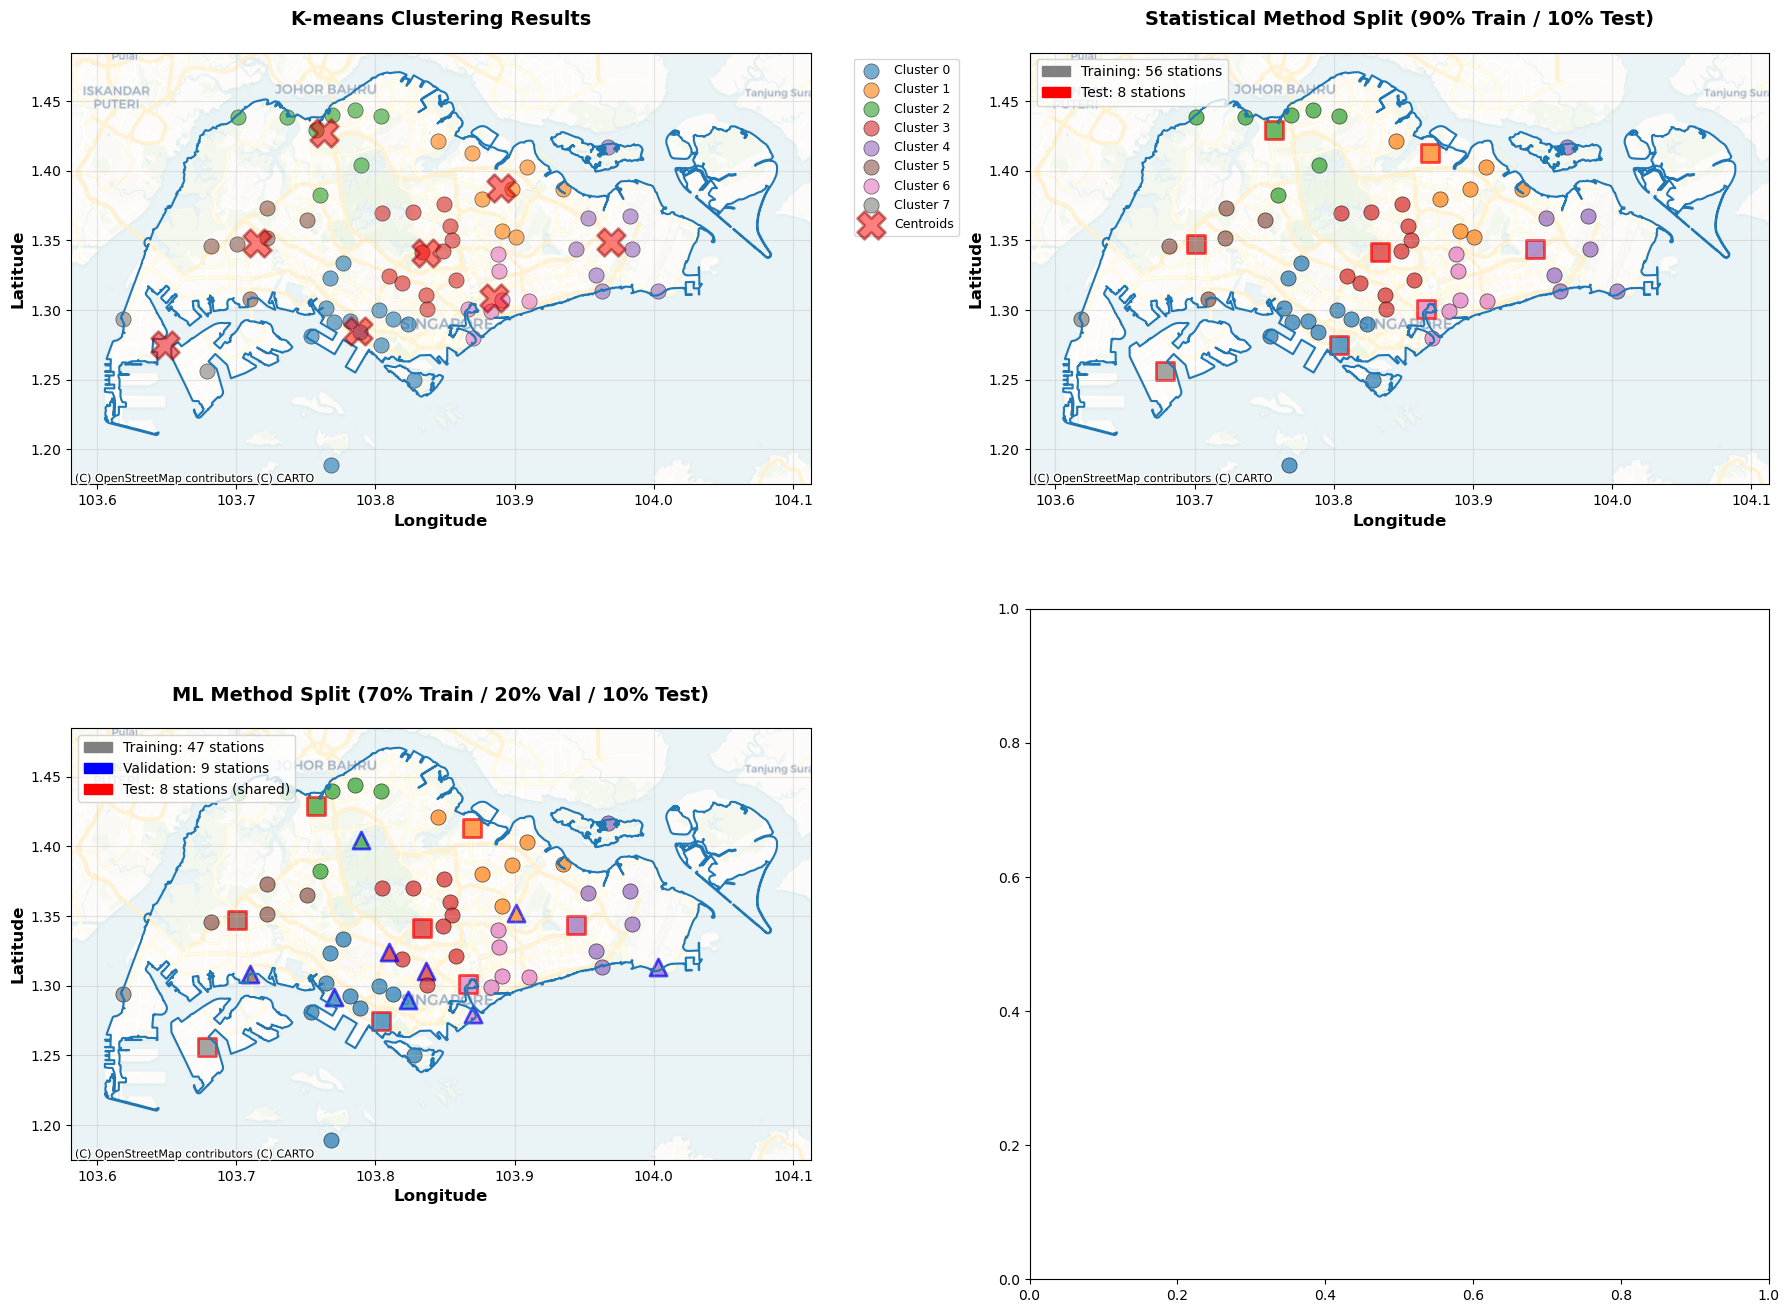


Creating Fold 2/5
Test stations: 8 (should be ~8)
Train pool: 56
Fold 2 summary:
  Statistical train: 56 (87.5%)
  Test: 8 (12.5%)
  ML train: 47 (73.4%)
  ML validation: 9 (14.1%)

Visualization saved as fold_2_sampling_results.png


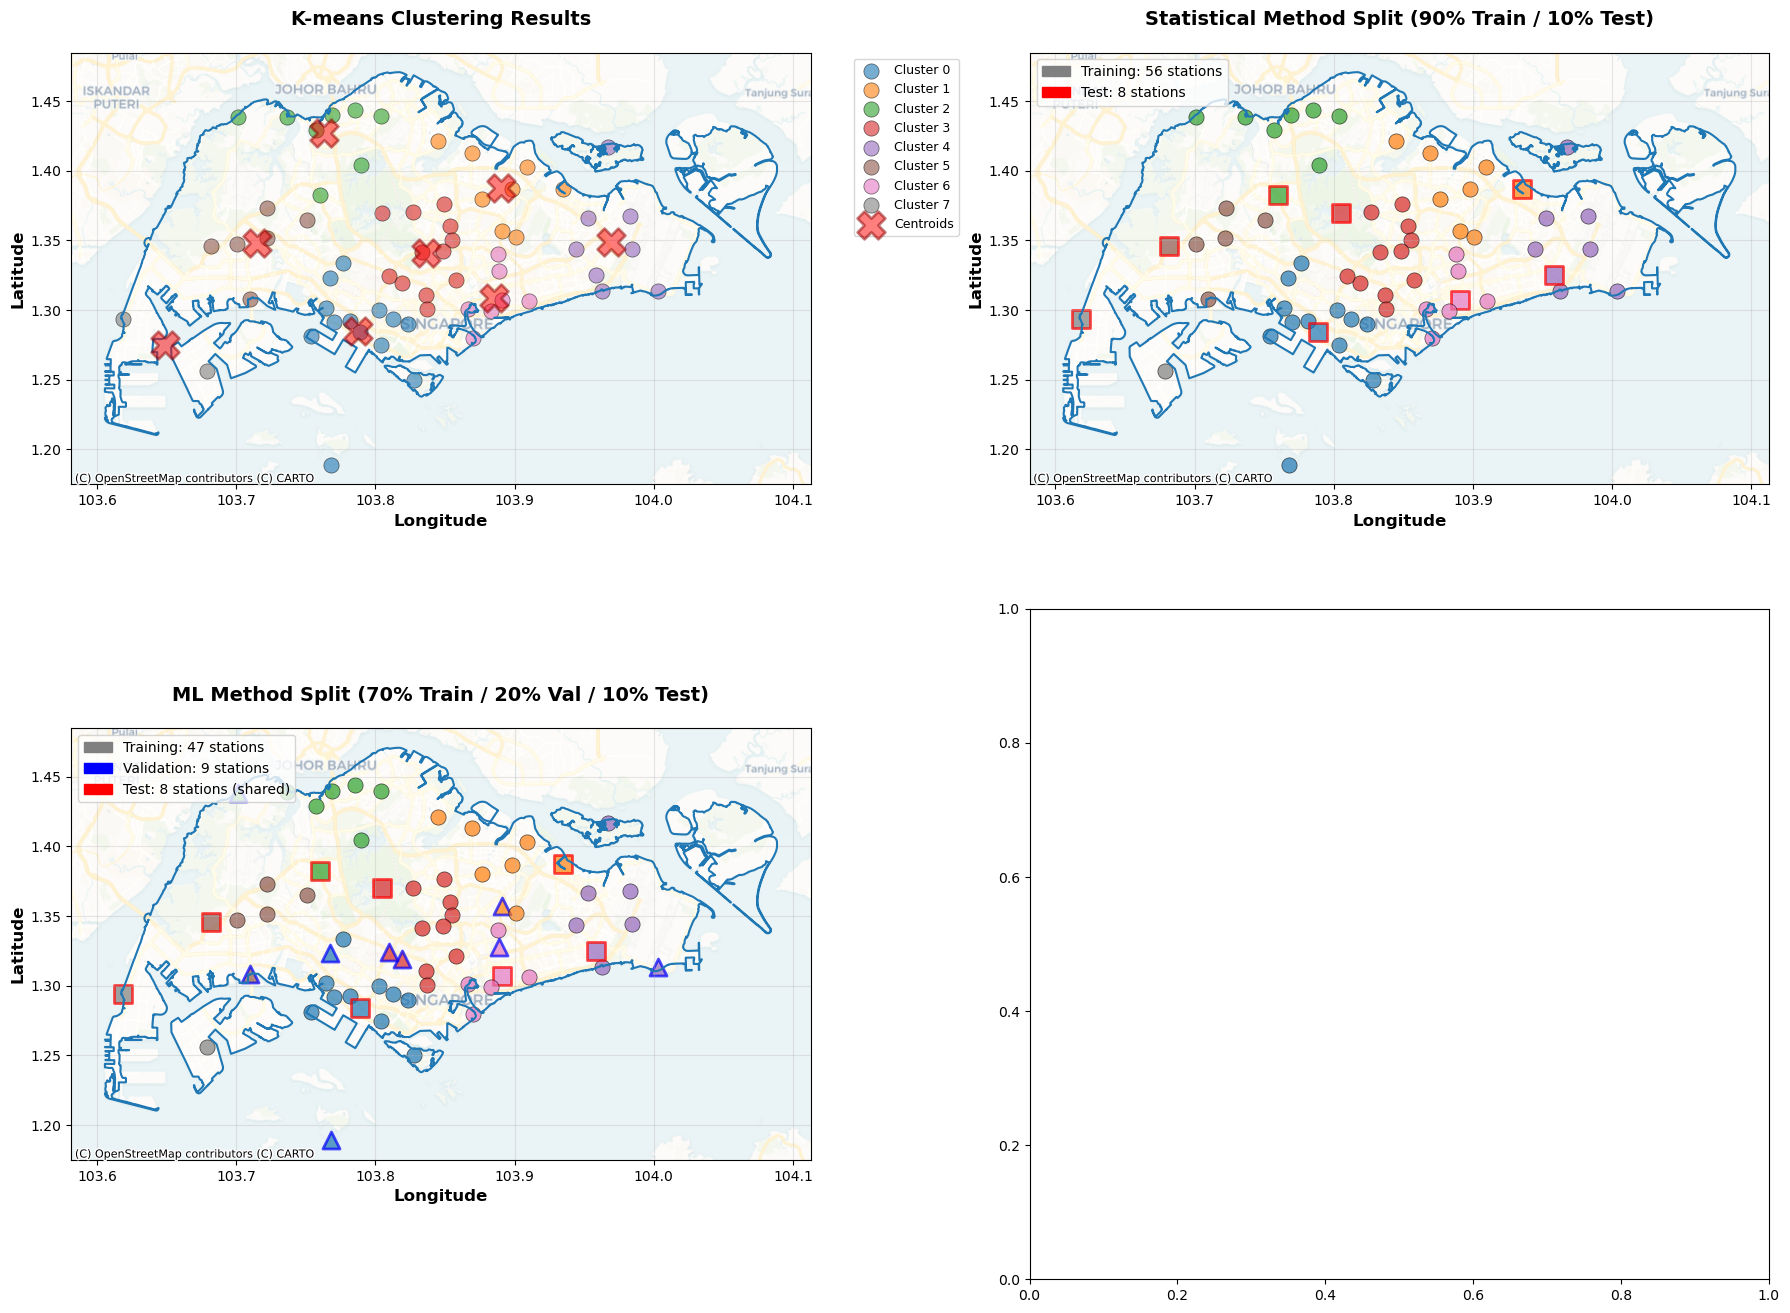


Creating Fold 3/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 3 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_3_sampling_results.png


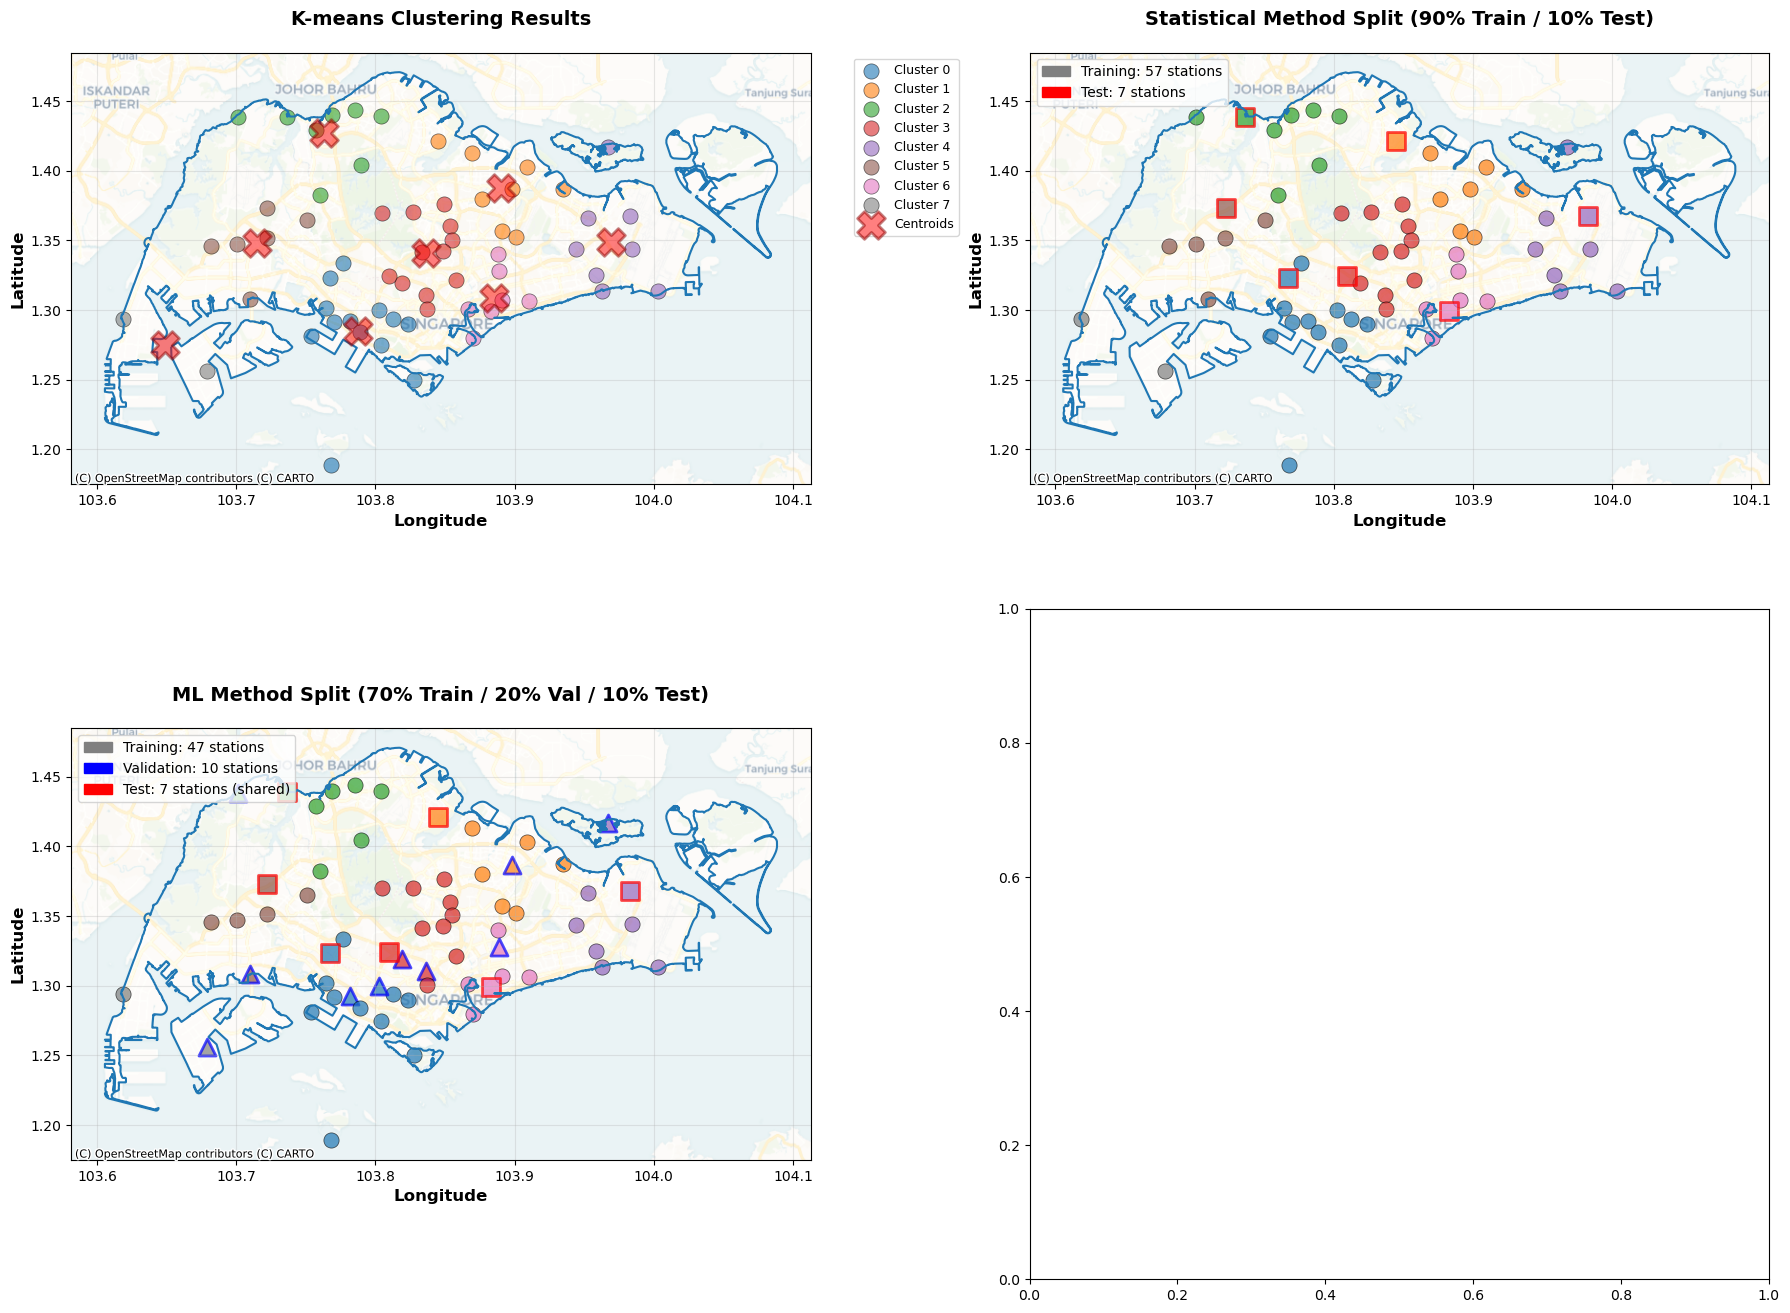


Creating Fold 4/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 4 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_4_sampling_results.png


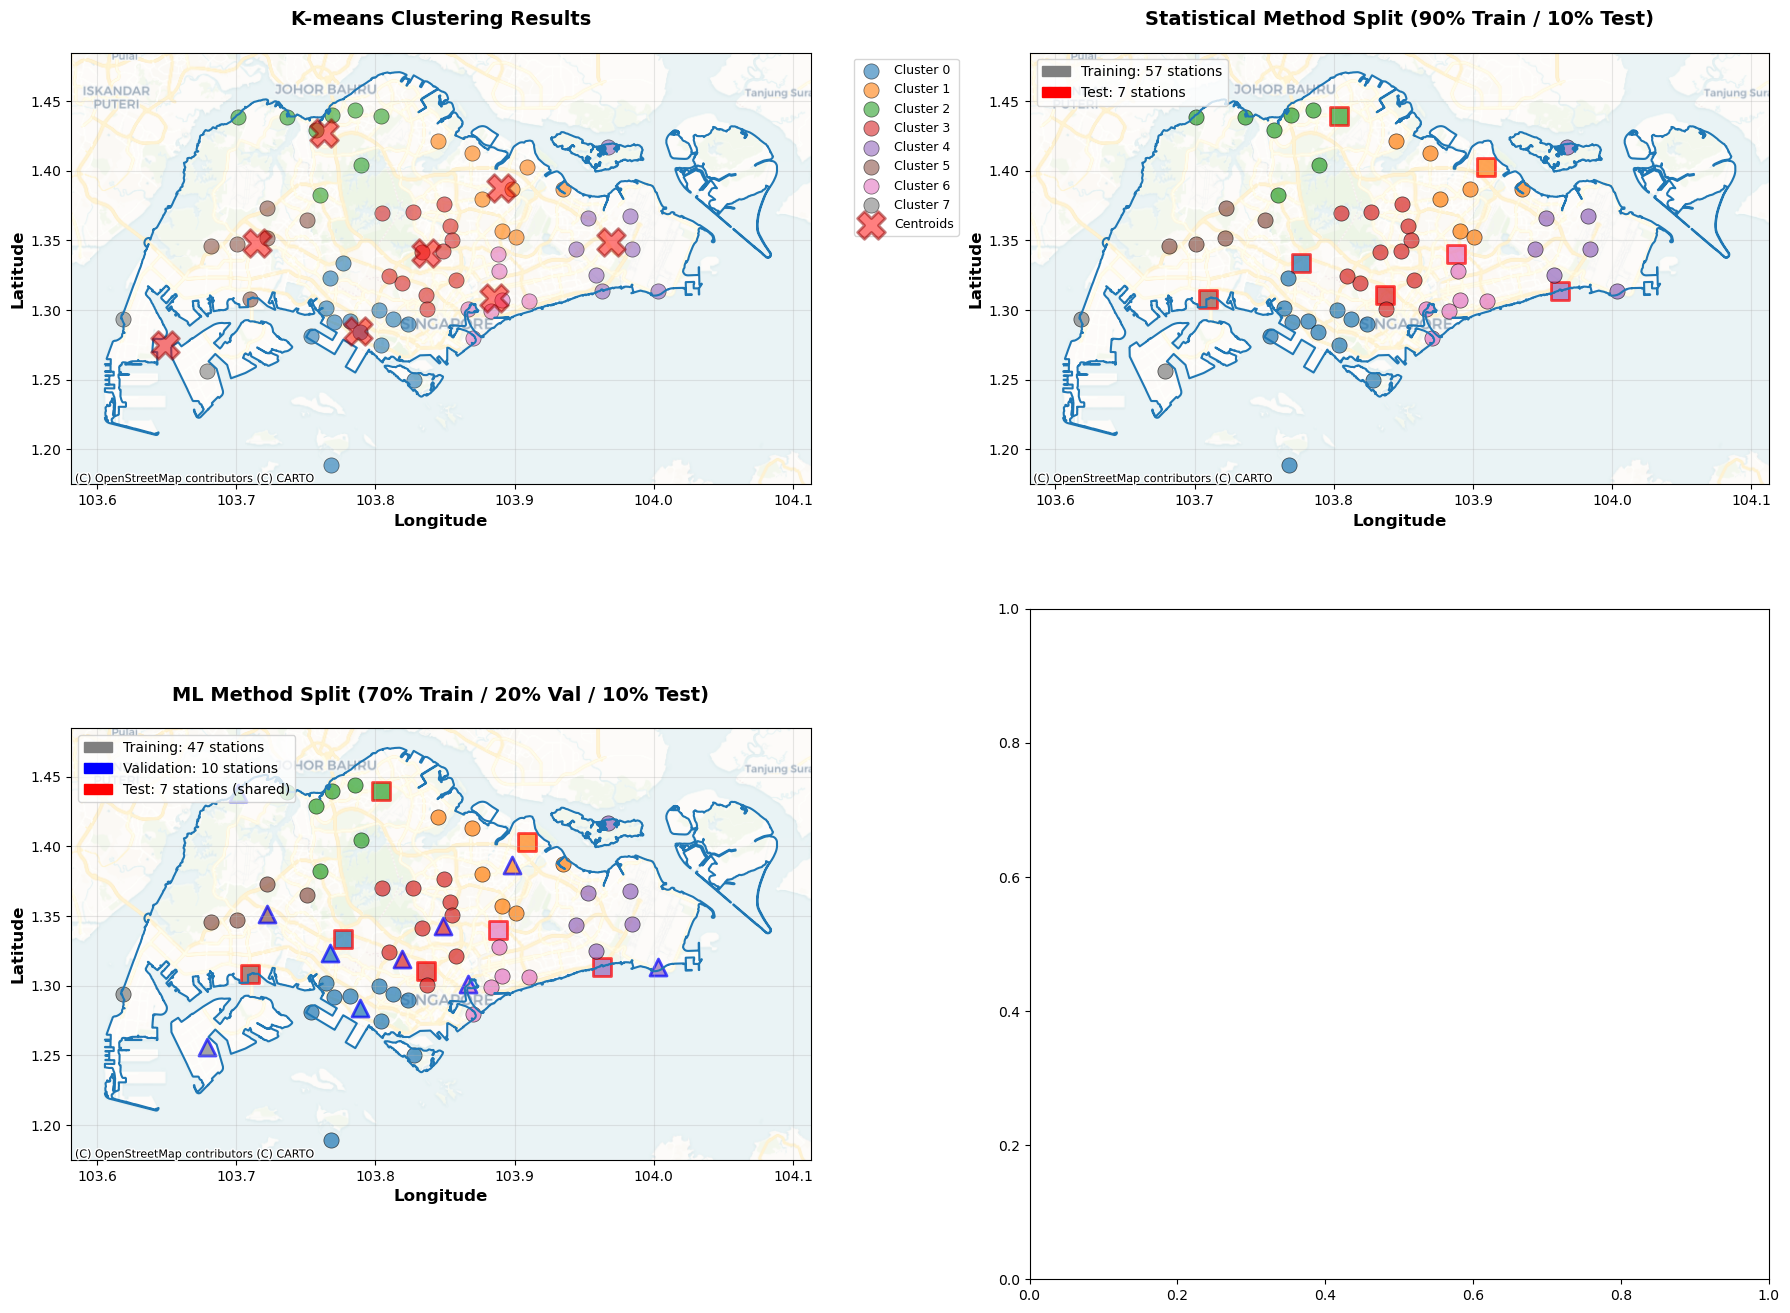


Creating Fold 5/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 5 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_5_sampling_results.png


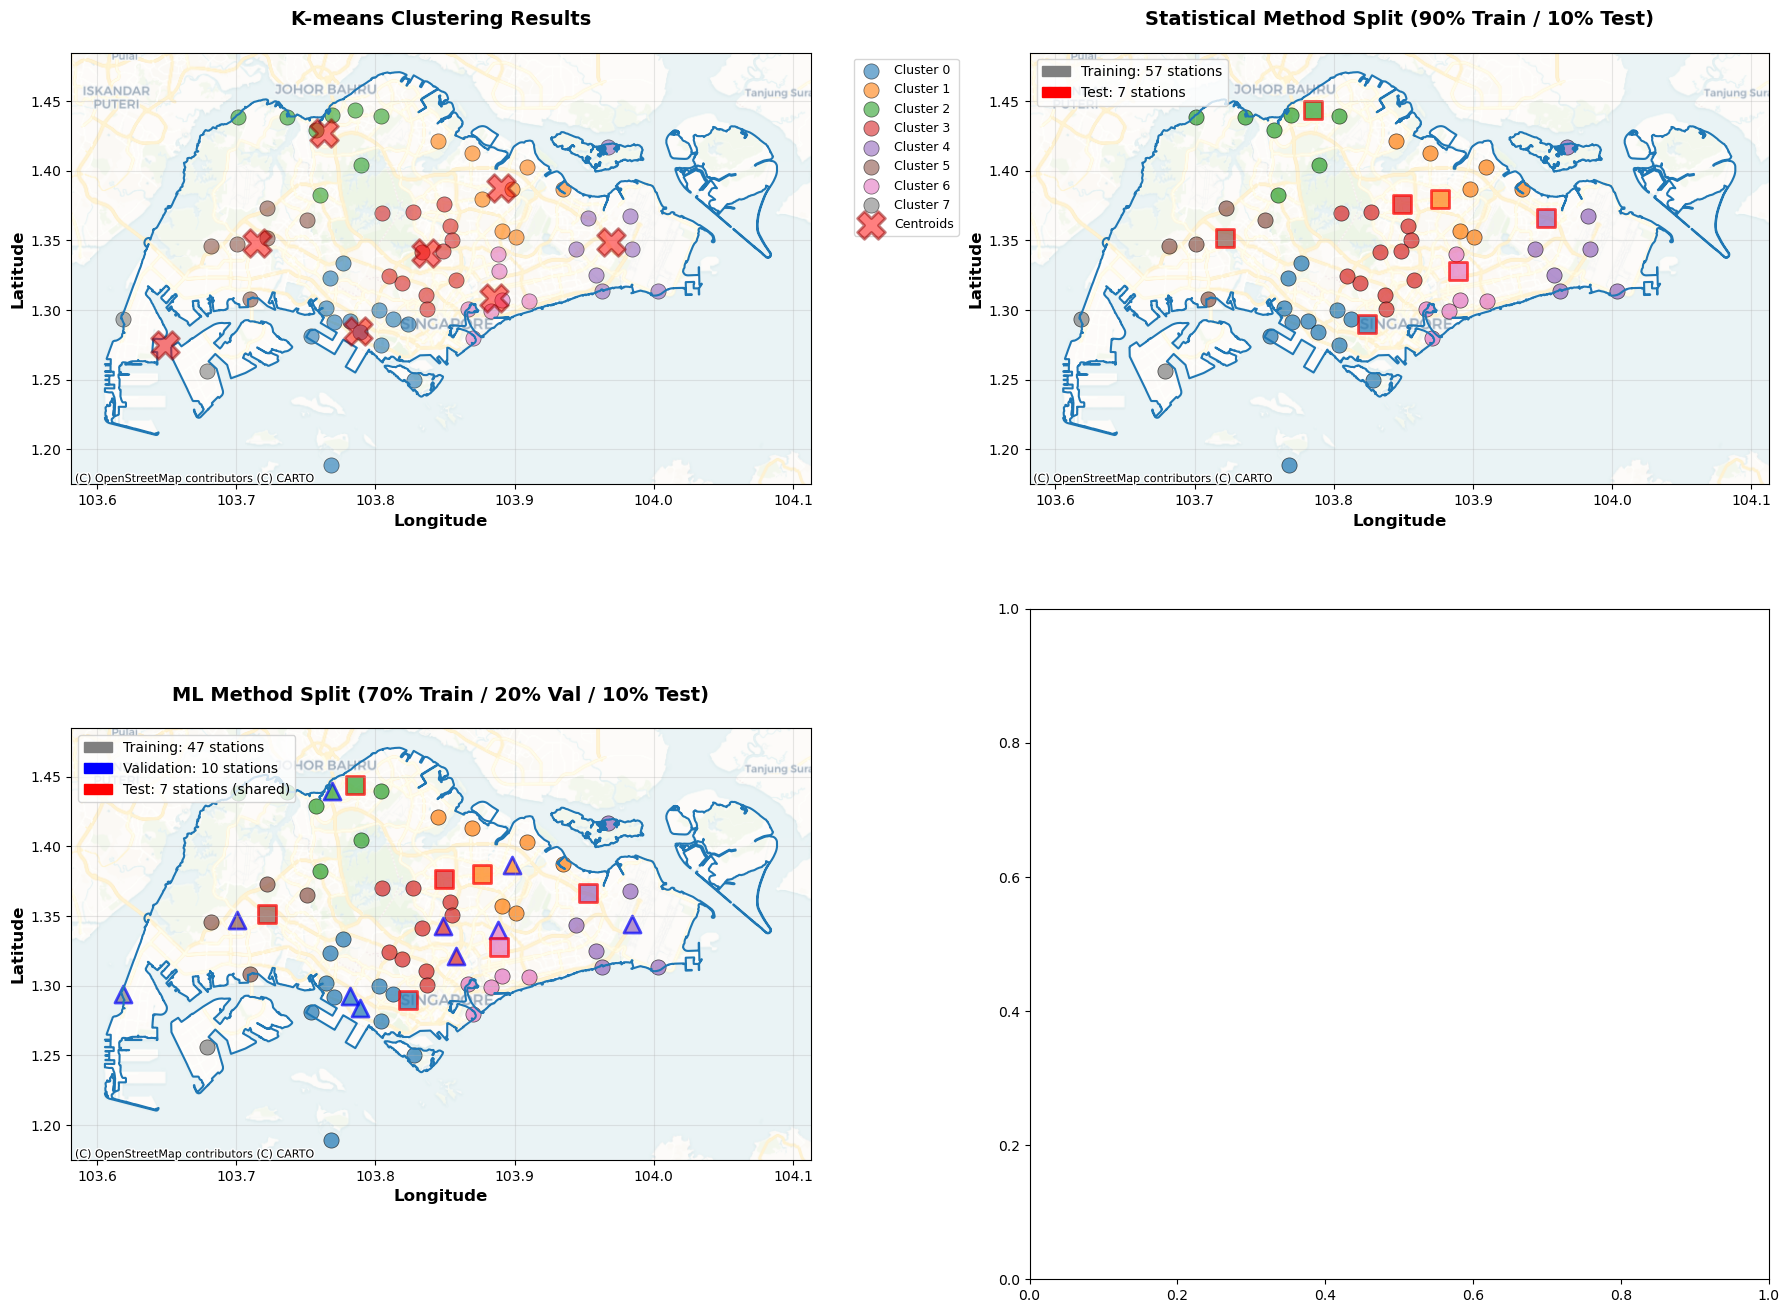


VERIFICATION
Total unique test stations across all folds: 37
Expected: 40
✓ K-Fold validation complete!
[{'fold_index': 0, 'statistical': {'train': array(['S92', 'S201', 'S50', 'S222', 'S203', 'S223', 'S230', 'S77',
       'S102', 'S71', 'S116', 'S60', 'S29', 'S209', 'S81', 'S219', 'S220',
       'S221', 'S06', 'S64', 'S66', 'S227', 'S104', 'S112', 'S40', 'S210',
       'S69', 'S213', 'S111', 'S109', 'S88', 'S123', 'S08', 'S90', 'S216',
       'S217', 'S79', 'S207', 'S24', 'S107', 'S94', 'S208', 'S224',
       'S106', 'S44', 'S121', 'S33', 'S229', 'S218', 'S78', 'S214', 'S43',
       'S215', 'S113', 'S108', 'S115'], dtype='<U4'), 'test': array(['S226', 'S900', 'S211', 'S07', 'S84', 'S228', 'S119', 'S117'],
      dtype='<U4')}, 'ml': {'train': array(['S92', 'S116', 'S60', 'S71', 'S102', 'S223', 'S230', 'S77', 'S50',
       'S201', 'S219', 'S29', 'S209', 'S81', 'S221', 'S220', 'S210',
       'S66', 'S112', 'S227', 'S64', 'S104', 'S217', 'S79', 'S08', 'S90',
       'S88', 'S123', 'S109',

In [10]:
split_info = stratified_spatial_kfold_dual(weather_station_locations, seed=123, plot=True)
print(split_info)

# data = add_mask_to_data(data, split_info[0], general_station, rainfall_station)
# data1 = add_mask_to_data(data1, split_info[1], general_station, rainfall_station)
data2 = add_mask_to_data(data2, split_info[2], general_station, rainfall_station)
# data3 = add_mask_to_data(data3, split_info[3], general_station, rainfall_station)
# data4 = add_mask_to_data(data4, split_info[4], general_station, rainfall_station)

# print("Data: \n", data)
# print("Data1: \n", data1)
print("Data2: \n", data2)
# print("Data3: \n", data3)
# print("Data4: \n", data4)


# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.


Total stations for KNN: 63
['S109', 'S50', 'S107', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06', 'S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
[[  1.3764  103.8492 ]
 [  1.3337  103.7768 ]
 [  1.3135  103.9625 ]
 [  1.34583 103.68166]
 [  1.4168  103.9673 ]
 [  1.31055 103.8365 ]
 [  1.189   103.768  ]
 [  1.25    103.8279 ]
 [  1.44387 103.78538]
 [  1.3399  103.8878 ]
 [  1.29377 103.61843]
 [  1.37288 103.72244]
 [  1.256   103.679  ]
 [  1.281   103.754  ]
 [  1.3524  103.9007 ]
 [  1.3415  103.8334 ]
 [  1.3701  103.8271 ]
 [  1.43854 103.70131]
 [  1.30648 103.9104 ]
 [  1.30105 103.8666 ]
 [  1.3214  103.8577 ]
 [  1.32

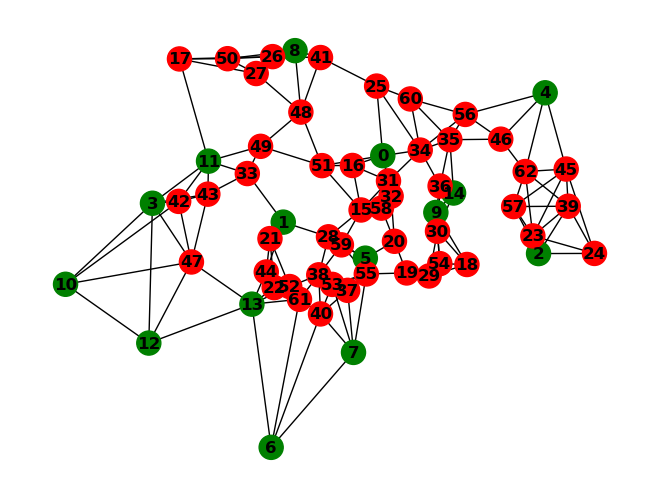

In [11]:
K = 4  # Number of neighbors per node
edges, edge_attributes = generate_edges(
    weather_station_locations,
    general_station,
    rainfall_station,
    K=K,
)

# data = add_edge_attributes_to_data(data, edges, edge_attributes, dtype=dtype)
# data1 = add_edge_attributes_to_data(data1, edges, edge_attributes, dtype=dtype)
data2 = add_edge_attributes_to_data(data2, edges, edge_attributes, dtype=dtype)
# data3 = add_edge_attributes_to_data(data3, edges, edge_attributes, dtype=dtype)
# data4 = add_edge_attributes_to_data(data4, edges, edge_attributes, dtype=dtype)

# print(data)
# print(data1)
print(data2)
# print(data3)
# print(data4)

In [12]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
# print_data_structure(data)
# print_data_structure(data1)
print_data_structure(data2)
# print_data_structure(data3)
# print_data_structure(data4)



FINAL HETERODATA STRUCTURE
HeteroData(
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
    station_ids=[15],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
    station_ids=[48],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (general_station, gen_to_rain, rainfall_station)={
    edge_index=[2, 50],
    edge_attr=[50, 1],
  },
  (rainfall_station, rain_to_gen, general_station)={
    edge_index=[2, 40],
    edge_attr=[40, 1],
  },
  (general_station, gen_to_gen, general_station)={
    edge_index=[2, 10],
    edge_attr=[10, 1],
  },
  (rainfall_station, rain_to_rain, rainfall_station)={
    edge_index=[2, 152],
    edge_attr=[152, 1],
  }
)

Node types: ['general_station', 'rainfall_station']
Edge types: [('general_station', 'gen_to_rain', 'rainfall_station'), ('rainfall_station', 'rain_to_gen', 'general_station'), ('general_station', 'gen_to_gen', 'general_station'), ('rain

In [13]:
# print(len(edge_attributes["rainfall_to_rainfall"]))

# # Process edge indices
# print(data)
# print(data.edge_types)

# print(data["general_station", "gen_to_rain", "rainfall_station"].edge_attr)
# print(data["rainfall_station", "rain_to_gen", "general_station"].edge_index)
# print(data["general_station", "gen_to_gen", "general_station"].edge_index)
# print(
#     len(
#         set(
#             data["rainfall_station", "rain_to_rain", "rainfall_station"]
#             .edge_index.detach()
#             .numpy()[0]
#         )
#     )
# )

# print(data.has_isolated_nodes())
# print(data.has_self_loops())
# print(data.is_undirected())

# print(data["general_station", "gen_to_rain", "rainfall_station"]["edge_index"])

# Creating the GNN

In [14]:
model = HeteroGNN(hidden_channels=8, out_channels=1, num_layers=5)
model1 = HeteroGNN(hidden_channels=8, out_channels=1, num_layers=5)
model2 = HeteroGNN(hidden_channels=8, out_channels=1, num_layers=5)
model3 = HeteroGNN(hidden_channels=8, out_channels=1, num_layers=5)
model4 = HeteroGNN(hidden_channels=8, out_channels=1, num_layers=5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)
model1.to(device=device)
model2.to(device=device)
model3.to(device=device)
model4.to(device=device)

HeteroGNN(
  (convs): ModuleList(
    (0-4): 5 x HeteroConv(num_relations=4)
  )
  (lin_rainfall): Linear(8, 1, bias=True)
  (lin_general): Linear(8, 1, bias=True)
)

In [15]:
def train_epoch(model, data, dataloader, optimizer, device, verbose=False, log_file="training_gnn_new_debug.log"):
    """Training loop with radar data."""
    model.train()
    epoch_losses = []

    charge_bar = tqdm.tqdm(dataloader, desc='training')

    # Setup logging if verbose
    if verbose:
        logger = logging.getLogger("train_debug")
        logger.setLevel(logging.INFO)
        if not logger.handlers:
            fh = logging.FileHandler(log_file, mode="a")
            fh.setFormatter(logging.Formatter("%(asctime)s - %(message)s"))
            logger.addHandler(fh)
        logger.info(f"=== Training Epoch Debug Log Started at {datetime.now()} ===")

    for batch in charge_bar:
        # Reset gradients ONCE per batch
        optimizer.zero_grad()

        edge_index_dict = batch["edge_index_dict"]
        edge_attribute_dict = batch["edge_attr_dict"]

        train_metastation_mask = torch.tensor(batch['metastation_mask'], dtype=torch.bool).to(device)
        train_rainfallstation_mask = torch.tensor(batch['rainfallstation_mask'], dtype=torch.bool).to(device)

        # Array containing MSE array
        # Should be list of tensor[stations, 1] of size batch which will be used to calculate average MSE for each timestamp
        batch_MSE_arr = [] 


        training_metastation_indices = train_metastation_mask.nonzero(as_tuple=False)
        training_rainfallstation_indices = train_rainfallstation_mask.nonzero(as_tuple=False)
            
        gen_x = batch['gen_x']
        rain_x = batch['rain_x']
        gen_y = batch['gen_y']
        rain_y = batch['rain_y']

        # Perform mask one
        for idx in training_metastation_indices:
            gen_x_masked = gen_x.clone()
            rain_x_masked = rain_x.clone()
        
            gen_x_masked[:, ~train_metastation_mask.bool()] = 0
            rain_x_masked[:, ~train_rainfallstation_mask.bool()] = 0
            gen_x_masked[:, idx, 0] = 0

            x_dict = {
                "general_station": gen_x_masked,
                "rainfall_station": rain_x_masked,
            }
                
                # NO optimizer.zero_grad() here!
            out = model(x_dict, edge_index_dict, edge_attribute_dict)

            gen_predictions = out['general_station'][:, idx]
            gen_actual = gen_y[:, idx]

            MSE_arr = (gen_predictions.squeeze() - gen_actual.squeeze()) ** 2
            batch_MSE_arr.append(MSE_arr)
                
            # if verbose:
            #     log_msg = f"""
            #         --- DEBUG STATS (General Station) ---
            #         Loss for this sample: {training_loss.item():.2f}
            #         """
            #     logger.info(log_msg)
                

            # Process rainfall stations
        for idx in training_rainfallstation_indices:
            gen_x_masked = gen_x.clone()
            rain_x_masked = rain_x.clone()
    
            gen_x_masked[:, ~train_metastation_mask.bool()] = 0
            rain_x_masked[:, ~train_rainfallstation_mask.bool()] = 0
            rain_x_masked[:, idx, 0] = 0

            x_dict = {
                'general_station': gen_x_masked,
                'rainfall_station': rain_x_masked,
            }

            # NO optimizer.zero_grad() here!
            out = model(x_dict, edge_index_dict, edge_attribute_dict)

            rain_predictions = out['rainfall_station'][:, idx]
            rainfall_actual = rain_y[:, idx]

            MSE_arr = (rain_predictions.squeeze() - rainfall_actual.squeeze()) ** 2
            
            # if verbose:
            #     log_msg = f"""
            #         --- DEBUG STATS (Rainfall Station) ---
            #         Loss for this sample: {training_loss.item():.2f}
            #         """
            #     logger.info(log_msg)
            
            batch_MSE_arr.append(MSE_arr)
        
        # Average loss across all masked stations in batch
        losses = torch.stack(batch_MSE_arr).mean()
        loss = torch.mean(torch.mean(losses, dim=0))
        epoch_losses.append(loss)

        # Backpropagate ONCE per batch
        loss.backward()

        # Update weights ONCE per batch
        optimizer.step()
    epoch_loss = torch.stack(epoch_losses).mean().item()

    return epoch_loss

In [16]:
def validate(model, data, dataloader, device):
    """Validation loop with radar data."""
    model.eval()  # Set to eval mode
    validation_loss_arr = []

    # Prepare masks
    val_gen_mask = torch.tensor(
        data["general_station"].val_mask, 
        dtype=torch.bool
    ).to(device)
    val_rain_mask = torch.tensor(
        data["rainfall_station"].val_mask, 
        dtype=torch.bool
    ).to(device)


    # Move edge data to device
    edge_index_dict = {key: val.to(device) for key, val in data.edge_index_dict.items()}
    edge_attr_dict = {key: val.to(device) for key, val in data.edge_attr_dict.items()}

    with torch.no_grad():  # No gradients during validation
        for batch in tqdm.tqdm(dataloader, desc="Validation"):
            gen_x = batch["gen_x"].to(device)
            rain_x = batch["rain_x"].to(device)
            gen_y = batch["gen_y"].to(device)
            rain_y = batch["rain_y"].to(device)

            batch_loss = 0

            # Mask train and test stations for validation
            gen_x_masked = gen_x.clone()
            rain_x_masked = rain_x.clone()

            gen_x_masked[:, ~val_gen_mask] = 0
            rain_x_masked[:, ~val_rain_mask] = 0

            # Create input dictionary with radar data
            x_dict = {
                "general_station": gen_x_masked,
                "rainfall_station": rain_x_masked,
            }

            out = model(x_dict, edge_index_dict, edge_attr_dict)

                # Calculate loss only on validation stations
            gen_predictions = out["general_station"][:, val_gen_mask]
            rain_predictions = out["rainfall_station"][:, val_rain_mask]

            gen_actual = gen_y[:, val_gen_mask]
            rain_actual = rain_y[:, val_rain_mask]

            preds = torch.cat([gen_predictions, rain_predictions], dim=1)
            actuals = torch.cat([gen_actual, rain_actual], dim=1)

            SE = (preds - actuals) ** 2
            batch_loss = torch.mean(torch.mean(SE))
                              
            validation_loss_arr.append(batch_loss)

    validation_loss = torch.mean(torch.stack(validation_loss_arr)).item()
    print(validation_loss)

    return validation_loss

In [17]:
# set seeds
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
perf.log_model_config(model.config)

batch_size = 16
# train_loader, val_loader = prepare_dataset_new(data, batch_size=batch_size)
# train_loader1, val_loader1 = prepare_dataset_new(data1, batch_size=batch_size)
train_loader2, val_loader2 = prepare_dataset_new(data2, batch_size=batch_size)
# train_loader3, val_loader3 = prepare_dataset_new(data3, batch_size=batch_size)
# train_loader4, val_loader4 = prepare_dataset_new(data4, batch_size=batch_size)

def train(model, data, train_loader, val_loader, fold, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    training_loss_arr = []
    validation_loss_arr = []
    early = 0
    mini = 1000
    stopping_condition = 5
    epochs = 0
    total_epochs = 20
    print(f"-----FOLD: {fold}-----")
    training_start = time.time()
    for i in range(total_epochs):
        print(f"-----EPOCH: {i + 1}-----")
        train_loss = train_epoch(
            model, data, train_loader, optimizer, device, verbose=False
        )
        validation_loss = validate(model, data, val_loader, device)
        training_loss_arr.append(train_loss)
        validation_loss_arr.append(validation_loss)
        perf.log_epoch(i, train_loss, validation_loss)
        if mini >= validation_loss:
            mini = validation_loss
            early = 0
        else:
            early += 1
        epochs += 1
        if early >= stopping_condition:
            print("Early stop loss")
            break

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {validation_loss:.4f}")

    training_end = time.time()
    total_time = training_end - training_start
    perf.finalise(total_time)

    print(f"Training took {total_time} seconds over {epochs} epochs")
    plt.plot(training_loss_arr, label="training_loss", color="blue")
    plt.plot(validation_loss_arr, label="validation_loss", color="red")
    plt.legend()
    plt.savefig(f"experiments/{experiment_name}/train_loss_plot_{fold}.png", dpi=300)
    plt.close()

    torch.save(model.state_dict(), f"experiments/{experiment_name}/weather_gnn_best_{fold}.pth")
    print("✅ model weights saved to weather_gnn_best.pth")

    perf.log_model_parameters(model)
    return model

# model = train(model, data, train_loader, val_loader, fold=0, device=device)
# model1 = train(model1, data1, train_loader1, val_loader1, fold=1, device=device)
model2 = train(model2, data2, train_loader2, val_loader2, fold=2, device=device)
# model3 = train(model3, data3, train_loader3, val_loader3, fold=3, device=device)
# model4 = train(model4, data4, train_loader4, val_loader4, fold=4, device=device)


-----FOLD: 2-----
-----EPOCH: 1-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 648.98it/s]


11.013236045837402
Train Loss: 13.8377
Validation Loss: 11.0132
-----EPOCH: 2-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 649.39it/s]


10.02885627746582
Train Loss: 13.6726
Validation Loss: 10.0289
-----EPOCH: 3-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 635.87it/s]


9.5237398147583
Train Loss: 13.5786
Validation Loss: 9.5237
-----EPOCH: 4-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 643.71it/s]


8.673892974853516
Train Loss: 13.4818
Validation Loss: 8.6739
-----EPOCH: 5-----


Validation: 100%|██████████| 546/546 [00:01<00:00, 536.34it/s]


7.011663913726807
Train Loss: 13.3236
Validation Loss: 7.0117
-----EPOCH: 6-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 637.06it/s]


5.665800094604492
Train Loss: 13.0991
Validation Loss: 5.6658
-----EPOCH: 7-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 590.32it/s]


4.670008182525635
Train Loss: 12.7622
Validation Loss: 4.6700
-----EPOCH: 8-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 598.04it/s]


3.9729065895080566
Train Loss: 12.3805
Validation Loss: 3.9729
-----EPOCH: 9-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 615.87it/s]


3.5078256130218506
Train Loss: 12.0052
Validation Loss: 3.5078
-----EPOCH: 10-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 612.37it/s]


3.231717586517334
Train Loss: 11.6292
Validation Loss: 3.2317
-----EPOCH: 11-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 618.66it/s]


3.076483726501465
Train Loss: 11.2597
Validation Loss: 3.0765
-----EPOCH: 12-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 614.59it/s]


2.989593029022217
Train Loss: 10.9032
Validation Loss: 2.9896
-----EPOCH: 13-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 615.51it/s]


3.0900392532348633
Train Loss: 10.5611
Validation Loss: 3.0900
-----EPOCH: 14-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 621.60it/s]


3.310516119003296
Train Loss: 10.2441
Validation Loss: 3.3105
-----EPOCH: 15-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 618.99it/s]


3.5913939476013184
Train Loss: 9.9694
Validation Loss: 3.5914
-----EPOCH: 16-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 619.77it/s]


3.9043490886688232
Train Loss: 9.7298
Validation Loss: 3.9043
-----EPOCH: 17-----


Validation: 100%|██████████| 546/546 [00:00<00:00, 618.59it/s]


4.244729042053223
Early stop loss
Training took 787.0746369361877 seconds over 17 epochs
✅ model weights saved to weather_gnn_best.pth


In [18]:
# print(next(iter(val_loader))["gen_x"].shape)

In [19]:
# total_params = sum(param.numel() for param in model.parameters())
# print(total_params)
# print(list(param for param in model.parameters()))


In [20]:
def test_model(model, data, device, collate_fn, fold=0):
    model.eval()
    total_rmse = 0

    # plot_preds = np.array([])
    # plot_actual = np.array([])
    plot_preds = []
    plot_actual = []
    gen_predictions_all = []
    rain_predictions_all = []
    gen_truth_all = []
    rain_truth_all = []

    station_ids_list = []
    timestep_list = []

    test_dataset = WeatherGraphDatasetNew(data, mode="test")

    test_gen_mask = torch.tensor(
        data["general_station"].test_mask, dtype=torch.bool
    ).to(device)
    test_rain_mask = torch.tensor(
        data["rainfall_station"].test_mask, dtype=torch.bool
    ).to(device)

    # NEW: Get actual station IDs for test nodes
    gen_test_station_ids = np.array(data["general_station"].station_ids)[test_gen_mask.cpu().numpy()]
    rain_test_station_ids = np.array(data["rainfall_station"].station_ids)[test_rain_mask.cpu().numpy()]

    edge_index_dict = {key: val.to(device) for key, val in data.edge_index_dict.items()}
    edge_attr_dict = {key: val.to(device) for key, val in data.edge_attr_dict.items()}

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        collate_fn=collate_fn,  # Use the passed-in collate_fn
    )

    count = 0
    timestep = 0
    printed_stats = False  # Flag to print stats only once
    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloader, desc="Testing"):
            gen_x = batch["gen_x"].to(device)
            rain_x = batch["rain_x"].to(device)
            gen_y = batch["gen_y"].to(device)
            rain_y = batch["rain_y"].to(device)

            batch_rmse = 0

            gen_x_masked = gen_x.clone()
            rain_x_masked = rain_x.clone()

            # Mask out all non-training nodes, as done in training
            gen_x_masked[:, ~test_gen_mask] = 0
            rain_x_masked[:, ~test_rain_mask] = 0

            x_dict = {
                "general_station": gen_x_masked,
                "rainfall_station": rain_x_masked,
            }

            out = model(x_dict, edge_index_dict, edge_attr_dict)

            # 3. Calculate predictions and targets on TEST nodes
            gen_predictions = out["general_station"][:, test_gen_mask]
            rain_predictions = out["rainfall_station"][:, test_rain_mask]

            gen_targets = gen_y[:, test_gen_mask]
            rain_targets = rain_y[:, test_rain_mask]

            # ==== DEBUGGING PRINT BLOCK ====
            if not printed_stats :
                print("\n--- DEBUG STATS (First Sample of Test Set) ---")

                print("\n--- INPUT FEATURES (Masked) ---")
                print(
                    f"General station features:  Min={x_dict['general_station'].min():.2f}, Max={x_dict['general_station'].max():.2f}, Mean={x_dict['general_station'].mean():.2f}"
                )

                print("\n--- MODEL PREDICTIONS (for TEST nodes) ---")
                if gen_predictions.numel() > 0:
                    print(
                        f"Pred (gen) tensor:    Min={gen_predictions.min():.2f}, Max={gen_predictions.max():.2f}, Mean={gen_predictions.mean():.2f}"
                    )
                else:
                    print("Pred (gen) tensor is empty for this batch.")

                if rain_predictions.numel() > 0:
                    print(
                        f"Pred (rain) tensor:   Min={rain_predictions.min():.2f}, Max={rain_predictions.max():.2f}, Mean={rain_predictions.mean():.2f}"
                    )
                else:
                    print("Pred (rain) tensor is empty for this batch.")

                print("\n--- GROUND TRUTH (for TEST nodes) ---")
                if gen_targets.numel() > 0:
                    print(
                        f"Truth (gen) tensor:    Min={gen_targets.min():.2f}, Max={gen_targets.max():.2f}, Mean={gen_targets.mean():.2f}"
                    )
                else:
                    print("Truth (gen) tensor is empty for this batch.")

                if rain_targets.numel() > 0:
                    print(
                        f"Truth (rain) tensor:   Min={rain_targets.min():.2f}, Max={rain_targets.max():.2f}, Mean={rain_targets.mean():.2f}"
                    )
                else:
                    print("Truth (rain) tensor is empty for this batch.")

                printed_stats = True
            # ===============================

            # plot_preds = np.concatenate(
            #     (
            #         plot_preds,
            #         gen_predictions.cpu().detach().numpy().flatten(),
            #         rain_predictions.cpu().detach().numpy().flatten(),
            #     )
            # )
            # plot_actual = np.concatenate(
            #     (
            #         plot_actual,
            #         gen_targets.cpu().detach().numpy().flatten(),
            #         rain_targets.cpu().detach().numpy().flatten(),
            #     )
            # )

            # gen_predictions_all.append(gen_predictions.cpu().detach().numpy().flatten(),)
            # rain_predictions_all.append(rain_predictions.cpu().detach().numpy().flatten(),)
            # gen_truth_all.append(gen_targets.cpu().detach().numpy().flatten(),)
            # rain_truth_all.append(rain_targets.cpu().detach().numpy().flatten(),)

            # # For general stations
            # for station_id in gen_test_station_ids:
            #     station_ids_list.append(station_id)
            #     timestep_list.append(timestep)
            
            # # For rainfall stations
            # for station_id in rain_test_station_ids:
            #     station_ids_list.append(station_id)
            #     timestep_list.append(timestep)

            # gen_MSE_arr = (gen_predictions - gen_targets) ** 2
            # rain_MSE_arr = (rain_predictions - rain_targets) ** 2

            # all_squared_errors = torch.cat([gen_MSE_arr, rain_MSE_arr])
            # test_rmse = torch.sqrt(torch.mean(all_squared_errors))

            # batch_rmse += test_rmse.item()
            # count += 1
            # timestep += 1
            gen_predictions_all.append(gen_predictions)
            rain_predictions_all.append(rain_predictions)
            gen_truth_all.append(gen_targets)
            rain_truth_all.append(rain_targets)
            
    print("DEBUG: PRINTS")
    gen_predictions_all = torch.stack(gen_predictions_all)
    rain_predictions_all = torch.stack(rain_predictions_all)
    gen_truth_all = torch.stack(gen_truth_all)
    rain_truth_all = torch.stack(rain_truth_all)

    #Contains tensor of all the values for the prediction and truth. 
    #The tensor was flattened from [number of batches, batch_size, stations, 1] to [timestamps, stations, 1] to make it easier to store values
    predictions_all = torch.cat([gen_predictions_all, rain_predictions_all], dim = 2).flatten(0,1)
    truth_all = torch.cat([gen_truth_all, rain_truth_all], dim = 2).flatten(0,1)

    print(predictions_all.shape)
    print(truth_all.shape)

    plot_preds = predictions_all.flatten().numpy()
    plot_actual = truth_all.flatten().numpy()

    mask = ~np.isnan(plot_actual) & ~np.isnan(
        plot_preds
    )  # Also check for NaNs in preds
    pearson_r_global, pearson_p_global = pearsonr(plot_actual[mask], plot_preds[mask])

    print(f"Pearson correlation (Test Stations): {pearson_r_global}")


    #Final RMSE is the average RMSE across each of the timestamps
    mse = (predictions_all - truth_all) ** 2
    rmse_arr = torch.sqrt(torch.mean(mse, dim = 1))
    print(rmse_arr.shape)
    final_rmse = torch.mean(rmse_arr)
    print(f"Final Test RMSE (Test Stations): {final_rmse}")

    perf.log_test_metrics(final_rmse, pearson_r_global)

    # Convert lists of arrays into one big array
    # gen_truth_all = np.concatenate(gen_truth_all, axis=0)
    # rain_truth_all = np.concatenate(rain_truth_all, axis=0)
    # gen_predictions_all = np.concatenate(gen_predictions_all, axis=0)
    # rain_predictions_all = np.concatenate(rain_predictions_all, axis=0)
    gen_truth_all = gen_truth_all.flatten().numpy()
    rain_truth_all = rain_truth_all.flatten().numpy()
    gen_predictions_all = gen_predictions_all.flatten().numpy()
    rain_predictions_all = rain_predictions_all.flatten().numpy()

    print(gen_truth_all.shape)

    # Now they are NumPy arrays, so flatten() works fine
    results_df = pd.DataFrame({
        "fold": fold,
        "station_type": (["general"] * len(gen_predictions_all.flatten())) 
                        + (["rainfall"] * len(rain_predictions_all.flatten())),
        "true_value": np.concatenate([
            gen_truth_all.flatten(),
            rain_truth_all.flatten()
        ], axis=0),
        "pred_value": np.concatenate([
            gen_predictions_all.flatten(),
            rain_predictions_all.flatten()
        ], axis=0),
    })

    # Compute absolute error
    results_df["abs_error"] = np.abs(results_df["pred_value"] - results_df["true_value"])

    # --- Mark cases where actual > 0 but predicted near zero ---
    results_df["is_false_zero"] = (
        (results_df["true_value"] > 0) & (results_df["pred_value"].between(0, 2))
    )

    # --- Save all results ---
    os.makedirs(f"experiments/{experiment_name}/predictions", exist_ok=True)
    results_df.to_csv(
        f"experiments/{experiment_name}/predictions/all_predictions_fold{fold}.csv", 
        index=False
    )

    # --- Save subset of "false zero" predictions ---
    false_zero_df = results_df[results_df["is_false_zero"]]
    false_zero_df.to_csv(
        f"experiments/{experiment_name}/predictions/false_zeros_fold{fold}.csv", 
        index=False
    )

    # print(fold)
    # print(station_ids_list)
    # print(timestep_list)
    # print(plot_actual)
    # print(plot_preds)
    # # --- Save station results ---
    # station_results_df = pd.DataFrame({
    #     "fold": fold,
    #     "station_id": station_ids_list,
    #     "timestep": timestep_list,
    #     "true_value": plot_actual,
    #     "pred_value": plot_preds
    # })
    # # Compute absolute error
    # station_results_df["abs_error"] = np.abs(station_results_df["pred_value"] - station_results_df["true_value"])

    # # Mark cases where actual > 0 but predicted near zero
    # station_results_df["is_false_zero"] = (
    #     (station_results_df["true_value"] > 0) & (station_results_df["pred_value"].between(0, 2))
    # )
    # station_results_df.to_csv(
    #     f"experiments/{experiment_name}/predictions/station_predictions_fold{fold}.csv", 
    #     index=False
    # )

    # # --- Save station errors ---
    # station_errors = station_results_df.groupby("station_id").agg({
    #     "abs_error": ["mean", "median", "max", "std"],
    #     "true_value": "mean",
    #     "pred_value": "mean"
    # }).reset_index()
    
    # station_errors.columns = ["station_id", "mean_abs_error", "median_abs_error", 
    #                            "max_abs_error", "std_abs_error", "mean_true", "mean_pred"]
    # station_errors["bias"] = station_errors["mean_pred"] - station_errors["mean_true"]
    # station_errors["fold"] = fold
    
    # station_errors.to_csv(
    #     f"experiments/{experiment_name}/predictions/station_errors_fold{fold}.csv",
    #     index=False
    # )

    # print(f"\nSaved prediction results for fold {fold}:")
    # print(f"  → all_predictions_fold{fold}.csv  ({len(results_df)} samples)")
    # print(f"  → station_errors_fold{fold}.csv  ({len(station_errors)} stations)")
    # print(f"  → false_zeros_fold{fold}.csv  ({len(false_zero_df)} false zeros)")
    
    # print("\nTop 5 worst stations by mean absolute error:")
    # print(station_errors.nlargest(5, "mean_abs_error")[["station_id", "mean_abs_error", "bias"]])

    # --- Plotting and Final Metrics ---
    plt.figure(figsize=(8, 8))
    plt.scatter(x=plot_actual, y=plot_preds, alpha=0.5)

    plot_bound = max(
        np.nanmax(plot_actual).astype(int), np.nanmax(plot_preds).astype(int)
    )
    plt.plot(np.linspace(0, plot_bound, 100), np.linspace(0, plot_bound, 100), "r--")

    plt.xlabel("Actual Rainfall (Test Stations)")
    plt.ylabel("Predicted Rainfall (Test Stations)")
    plt.title("Test Set Performance")
    plt.grid(True)

    # put metrics on the figure (top-left corner)
    text_str = f"Pearson r = {pearson_r_global:.3f}\nTest RMSE = {final_rmse:.3f}"
    plt.text(
        0.05,
        0.95,
        text_str,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )

    plt.savefig(f"experiments/{experiment_name}/test_scatter_plot_{fold}.png", dpi=300)
    plt.close()
    print(
        f"Saved test scatter plot to 'experiments/{experiment_name}/test_scatter_plot_{fold}.png'"
    )

    return final_rmse

In [21]:
from src.utils import collate_temporal_graphs_new


# RMSE = test_model(model, data, device, collate_temporal_graphs_new, fold=0)
# RMSE1 = test_model(model1, data1, device, collate_temporal_graphs_new, fold=1)
RMSE2 = test_model(model2, data2, device, collate_temporal_graphs_new, fold=2)
# RMSE3 = test_model(model3, data3, device, collate_temporal_graphs_new, fold=3)
# RMSE4 = test_model(model4, data4, device, collate_temporal_graphs_new, fold=4)
# print(f"TEST RMSE: {RMSE}")
# print(f"TEST RMSE1: {RMSE1}")
print(f"TEST RMSE2: {RMSE2}")
# print(f"TEST RMSE3: {RMSE3}")
# print(f"TEST RMSE4: {RMSE4}")

Testing:  23%|██▎       | 126/546 [00:00<00:00, 626.93it/s]


--- DEBUG STATS (First Sample of Test Set) ---

--- INPUT FEATURES (Masked) ---
General station features:  Min=0.00, Max=355.00, Mean=2.16

--- MODEL PREDICTIONS (for TEST nodes) ---
Pred (gen) tensor:    Min=0.17, Max=1.31, Mean=0.97
Pred (rain) tensor:   Min=0.19, Max=0.19, Mean=0.19

--- GROUND TRUTH (for TEST nodes) ---
Truth (gen) tensor:    Min=0.00, Max=0.00, Mean=0.00
Truth (rain) tensor:   Min=0.00, Max=0.00, Mean=0.00


Testing: 100%|██████████| 546/546 [00:00<00:00, 628.40it/s]


DEBUG: PRINTS
torch.Size([8736, 7, 1])
torch.Size([8736, 7, 1])
Pearson correlation (Test Stations): 0.6104302406311035
torch.Size([8736, 1])
Final Test RMSE (Test Stations): 2.6971328258514404
(8736,)
Saved test scatter plot to 'experiments/20251113_235213_new/test_scatter_plot_2.png'
TEST RMSE2: 2.6971328258514404


# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [22]:
def visualize_one_event(test_event_data, radar_features_event, do_plot=True):
    """
    Prepare a single example from `test_event_data` (a pandas slice like
    weather_station_df_pivot.iloc[593:602]) and run the model for inference.

    This function returns:
      gen_out: numpy array of predicted general_station outputs (shape: [num_gen_nodes, out_features])
      rain_out: numpy array of predicted rainfall_station outputs (shape: [num_rain_nodes, out_features])
    """
    model.eval()

    # clone template (so we keep masks/edge_index/order)
    test_data = data.clone()

    # --- collect station-wise time-series just like you had before ---
    test_general_station_data = {}
    test_rainfall_station_data = {}

    for station in test_event_data.columns.get_level_values(1).unique():
        station_cols = (
            test_event_data.xs(station, level=1, axis=1)
            .interpolate(method="linear")
            .fillna(method="ffill")
            .fillna(method="bfill")
        )
        if station in general_station:
            test_general_station_data[station] = (
                station_cols.values
            )  # shape [T, gen_feat]
        else:
            test_rainfall_station_data[station] = station_cols.values[
                :, 0:1
            ]  # [T, rain_feat=1]

    # Build arrays in the correct node ordering
    gen_feats_list = []
    rain_feats_list = []

    for station in general_station:
        gen_feats_list.append(
            test_general_station_data[station]
        )  # each item: [T, gen_feat_per_t]
    for station in rainfall_station:
        rain_feats_list.append(
            test_rainfall_station_data[station]
        )  # each item: [T, rain_feat_per_t]

    # Convert to numpy arrays and get shapes
    # After np.array(gen_feats_list) => shape [num_gen_nodes, T, gen_feat_per_t]
    gen_arr = np.array(gen_feats_list)  # [N_gen, T, Fg]
    rain_arr = np.array(rain_feats_list)  # [N_rain, T, Fr]

    # --- Convert to the 2-D node-feature format the model expects ---
    # There are different sensible choices here:
    #  - take last timestep: arr[:, -1, :] -> [N, F]
    #  - flatten the time axis into the feature axis: arr.reshape(N, T*F)
    # The training/test collate you used produces per-node features (no time dim).
    # To match that, we flatten time into features (preserves the whole window).
    def flatten_time_axis(arr):
        # arr: [N, T, F]
        N, T, F = arr.shape
        return arr.reshape(N, T * F)  # [N, T*F]

    gen_node_feats = gen_arr[:, -1, :].astype(np.float32)
    rain_node_feats = rain_arr[:, -1, :].astype(np.float32)  # [N, F]
    radar_node_feats = radar_features_event[-1].float()  # [N_radar, F]

    # Convert to torch tensors (2-D per node type) and move to device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    x_dict = {
        "general_station": torch.tensor(
            gen_node_feats, dtype=torch.float, device=device
        ),
        "rainfall_station": torch.tensor(
            rain_node_feats, dtype=torch.float, device=device
        ),
        "radar_grid": torch.tensor(radar_node_feats, dtype=torch.float, device=device),
    }

    # Move edge structures to device (the same ones you used in test_model)
    edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}

    # Run model
    with torch.no_grad():
        out = model(x_dict, edge_index_dict, edge_attr_dict)

    # out[...] are torch tensors shaped like [num_nodes, out_features] (depending on your model head)
    gen_out = out["general_station"].cpu().numpy()
    rain_out = out["rainfall_station"].cpu().numpy()

    return gen_out, rain_out


In [23]:
test_event_data = weather_station_df_pivot.iloc[593:602]  # your 9 timestamps
radar_features_event = data["radar_grid"].x[593:602]
gen_out, rain_out = visualize_one_event(test_event_data, radar_features_event)
out_np = np.concatenate([gen_out, rain_out], axis=0)

NameError: name 'data' is not defined

In [ ]:
print(test_data.edge_index_dict)

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [ ]:
print(out_np / 12)

# Visualize Radar Image

In [ ]:
radar_df = load_radar_dataset("sg_radar_data")

visualize_one_radar_image(radar_df=radar_df)

In [ ]:
# fig, ax = plt.subplots(
#     3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()}
# )

# out_np = out_np / 12
# for idx, timestamp in enumerate(out_np):
#     output = {}
#     count = 0

#     for stn in general_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     for stn in rainfall_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     axi = ax[idx // 3][idx % 3]
#     node_df = pd.Series(output)
#     node_df = pandas_to_geodataframe(node_df)
#     visualise_gauge_grid(node_df=node_df, ax=axi)
#     improved_visualise_radar_grid(
#         radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm
#     )
#     visualise_singapore_outline(ax=axi)

In [ ]:
original_rainfall_rates = (
    weather_station_df_pivot.iloc[1773:1797].resample("15min").first()["rain_rate"]
)


print(original_rainfall_rates)

In [ ]:
print(out)

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
    output = {}
    count = 0
    a_arr = []
    p_arr = []

    for stn in general_station:
        output[stn] = float(timestamp[count])
        count += 1
    for stn in rainfall_station:
        output[stn] = float(timestamp[count])
        count += 1

    for key, value in output.items():
        a_arr.append(original_rainfall_rates.iloc[idx][key])
        p_arr.append(output[key])
    a_arr = list(map(lambda x: float(x), a_arr))
    actual_arr.append(a_arr)
    pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
    error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])